In [121]:
import torch
import torch.nn as nn
import torch.optim as optim



In [122]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device))

A cpu device was detected.


In [123]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
path='/content/drive/MyDrive/Colab Notebooks/Combined_Data - Sheet1.csv'
df=pd.read_csv(path)
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [125]:
df.shape

(47840, 5)

In [126]:
#standardize the dataset

#Calculate Mean
meanAT=df['AT'].mean()
meanV=df['V'].mean()
meanAP=df['AP'].mean()
meanRH=df['RH'].mean()
meanPE=df['PE'].mean()

#Calculate Standard Deviation

stdAT=df['AT'].std()
stdV=df['V'].std()
stdAP=df['AP'].std()
stdRH=df['RH'].std()
stdPE=df['PE'].std()

df['AT']=(df['AT']-meanAT)/stdAT
df['V']=(df['V']-meanV)/stdV
df['AP']=(df['AP']-meanAP)/stdAP
df['RH']=(df['RH']-meanRH)/stdRH
df['PE']=(df['PE']-meanPE)/stdPE

df.head()

,AT,V,AP,RH,PE
0,-0.629513,-0.987286,1.820469,-0.009519,0.521203
1,0.741901,0.681038,1.141851,-0.974610,-0.585658
2,-1.951277,-1.173005,-0.185076,1.289826,2.003658
3,0.162204,0.237201,-0.508388,0.228158,-0.462023
4,-1.185056,-1.322525,-0.678463,1.596683,1.144654


In [127]:
inputs=['AT','V','AP','RH']
X=torch.tensor(df[inputs].values, dtype=torch.float32, device=device)

output=['PE']
y=torch.tensor(df[output].values, dtype=torch.float32, device=device)

In [128]:
X[0:4]

tensor([[-0.6295, -0.9873,  1.8205, -0.0095],
        [ 0.7419,  0.6810,  1.1419, -0.9746],
        [-1.9513, -1.1730, -0.1851,  1.2898],
        [ 0.1622,  0.2372, -0.5084,  0.2282]])

In [129]:
y[0:4]

tensor([[ 0.5212],
        [-0.5857],
        [ 2.0037],
        [-0.4620]])

In [130]:
from sklearn.model_selection import train_test_split
X_train_valid,X_test,y_train_valid,y_test=train_test_split(X,y,test_size=0.2,random_state=3)

X_train,X_valid,y_train,y_valid=train_test_split(X_train_valid,y_train_valid,test_size=0.25,random_state=3)


In [131]:
from torch.nn.modules.activation import ReLU
# No of input layers = 4
# No of output layers = 1
# No of hidden layers = 2
# Activation Function = ReLU
# No of hidden units = 64 and 32

model=nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,1),

)
model.to(device)


Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

In [132]:
#Training the neural network

criterion=torch.nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)

for epoch in range(5):
  totalLoss=0
  for i in range(len(X_train)):
    ypred=model(X_train[i])
    loss=criterion(ypred,y_train[i])
    totalLoss+=loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("Total Loss= ", totalLoss)


Total Loss=  2309.600176190775
Total Loss=  2133.511808042405
Total Loss=  2135.148515453777
Total Loss=  2121.3808467512085
Total Loss=  2107.461257884373


In [133]:
@torch.no_grad()
def graph(model,X_train,y_train,min,max):
  model.eval()
  prediction=[]
  actual=[]

  X_train.to(device)
  y_train.to(device)
  model.to(device)

  for i in range(len(X_train)):
    pred=model(X_train[i])
    pred=pred*stdPE + meanPE

    act=y_train[i]*stdPE +meanPE

    prediction.append(pred.tolist())
    actual.append(act.item())

  import matplotlib.pyplot as plt
  plt.scatter(actual,prediction)
  plt.xlabel('Actual PE')
  plt.ylabel('Predicted PE')

  plt.plot([min,max],[min,max])
  plt.xlim(min,max)
  plt.ylim(min,max)

  plt.show()
  

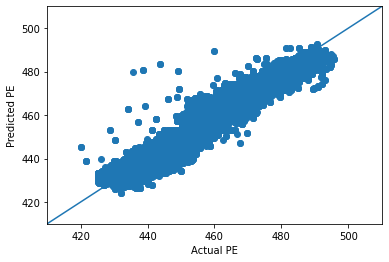

In [134]:
graph(model,X_train,y_train,410,510)

In [135]:
#Validation

criterion=torch.nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.01)

for epoch in range(5):
  totalLoss=0
  for i in range(len(X_valid)):
    ypred=model(X_valid[i])
    loss2=criterion(ypred,y_valid[i])
    totalLoss+=loss2.item()
    optimizer.zero_grad()
    loss2.backward()
    optimizer.step()

  print("Total Loss= ", totalLoss)



Total Loss=  713.6059681945128
Total Loss=  714.0754888347034
Total Loss=  714.6927259913297
Total Loss=  712.6238978337336
Total Loss=  711.2779804280275


In [136]:
@torch.no_grad()
def graph2(model,X_valid,y_valid,min,max):
  model.eval()
  prediction2=[]
  actual2=[]

  X_valid.to(device)
  y_valid.to(device)
  model.to(device)

  for i in range(len(X_valid)):
    pred2=model(X_valid[i])
    pred2=pred2*stdPE + meanPE

    act2=y_valid[i]*stdPE +meanPE

    prediction2.append(pred2.tolist())
    actual2.append(act2.item())

  import matplotlib.pyplot as plt
  plt.scatter(actual2,prediction2)
  plt.xlabel('Actual PE')
  plt.ylabel('Predicted PE')

  plt.plot([min,max],[min,max])
  plt.xlim(min,max)
  plt.ylim(min,max)

  plt.show()

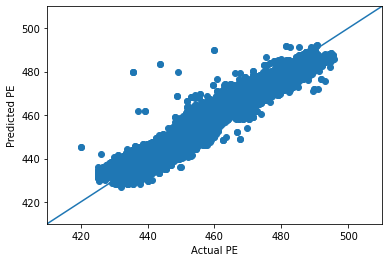

In [137]:
graph2(model,X_valid,y_valid,410,510)

In [138]:
#Test Dataset

criterion=torch.nn.MSELoss()

for epoch in range(5):
  totalLoss=0
  for i in range(len(X_test)):
    ypred=model(X_test[i])
    loss3=criterion(ypred,y_test[i])
    totalLoss+=loss3.item()
    

In [139]:
@torch.no_grad()
def graph3(model,X_test,y_test,min,max):
  model.eval()
  prediction3=[]
  actual3=[]

  X_test.to(device)
  y_test.to(device)
  model.to(device)

  for i in range(len(X_test)):
    pred3=model(X_test[i])
    pred3=pred3*stdPE + meanPE

    act3=y_test[i]*stdPE +meanPE

    prediction3.append(pred3.tolist())
    actual3.append(act3.item())

  import matplotlib.pyplot as plt
  plt.scatter(actual3,prediction3)
  plt.xlabel('Actual PE')
  plt.ylabel('Predicted PE')

  plt.plot([min,max],[min,max])
  plt.xlim(min,max)
  plt.ylim(min,max)

  plt.show()

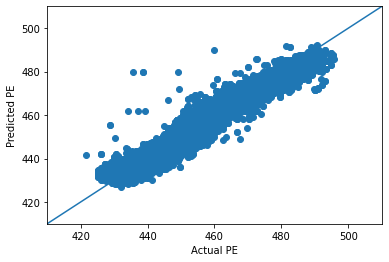

In [140]:
graph3(model,X_test,y_test,410,510)